In [13]:
from auxiliary import loadData_staticTargetAddrMatch, prepare_data_loaders, create_sequential_inference_loader
from auxiliary import normalize_rss_data, denormalize_predictions, denormalize_rss, plot_rss_vs_position
from auxiliary import plot_sequential_results, run_sequential_inference, apply_normalization
from algorithms import RssPosAlgo_NeuralNet_CNNv1
from algorithms import RssPosAlgo_NeuralNet_supervisedTrainingLoop
from algorithms import RssPosAlgo_NearestNeighbour
from algorithms import RssPosAlgo_NearestNeighbour_Interpolation
from algorithms import RssPosAlgo_NearestNeighbour_GetKmeansDb
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [14]:
target_adresses = ["d8:47:32:eb:6c:38",
                    "50:c7:bf:19:e6:4d",
                    "18:28:61:3d:94:7a"]

In [15]:
for idx, i in enumerate([5,6,7,8]):
    datajsonpath = "../experiments/exp00"+str(i)+"_20250526_sna_kadirerdem/data-tshark/data.json"
    inp_rss_vals1, gt_locations1 = loadData_staticTargetAddrMatch(datajsonpath, second_hold = 5, shuffle=False, 
                                                                target_addresses=target_adresses, snap250ms=False)
    if(idx == 0):
        inp_rss_vals = inp_rss_vals1
        gt_locations = gt_locations1
    else:
        inp_rss_vals = np.concatenate((inp_rss_vals, inp_rss_vals1),axis=0)
        gt_locations = np.concatenate((gt_locations, gt_locations1),axis=0)

In [16]:
norm_params_manual = {
    'rss_mean': np.asarray([-65.0, -65.0, -65.0]),
    'rss_std':  np.asarray([20.0, 20.0, 20.0]),
    'loc_mean': np.asarray([2.0, 2.0]),
    'loc_std':  np.asarray([2.0, 2.0])
}

In [17]:
batch_size       = 64
train_test_split = 0.30
kernel_sizes     = [13, 13, 13, 13]  # Changed from single kernelsize to list
channels         = [32, 32, 32, 2]
total_reduction  = sum(k - 1 for k in kernel_sizes)
min_input_length = total_reduction + 1
window_size      = min_input_length # 50
print("Window size:", window_size)

# Normalize your data before training
#inp_rss_vals_norm, gt_locations_norm, norm_params = normalize_rss_data(
#    inp_rss_vals, gt_locations, 
#    fit_on_train=True, 
#    train_split=train_test_split
#)
norm_params = norm_params_manual
inp_rss_vals_norm, gt_locations_norm, _ = apply_normalization(inp_rss_vals, gt_locations, norm_params_manual)

# Use normalized data for training
train_loader, test_loader, xtr, ytr, xts, yts = prepare_data_loaders(
    inp_rss_vals_norm, gt_locations_norm, 
    batch_size=batch_size, window_size=window_size,
    train_test_split=train_test_split,
    cnn_data=True, cnn_kernel_sizes=kernel_sizes
)

Window size: 49


In [18]:
lmd_x = 0.75;
lmd_y = 1-lmd_x;
def loss_fn(i,t):
    x_err = lmd_x*(i[:,0,0] - t[:,0,0])
    y_err = lmd_y*(i[:,1,0] - t[:,1,0])
    loss = torch.mean(torch.sqrt(x_err**2 + y_err**2))
    return loss
#cnn_criterion = loss_fn
cnn_criterion = nn.MSELoss(reduction='mean')

In [19]:
print("Subset sizes | train:", xtr.shape, ", test:",xts.shape)
cnn = RssPosAlgo_NeuralNet_CNNv1(channels, kernel_sizes)
cnn.train()
cnn.cuda()
cnn.device="cuda"

cnn_optimizer = optim.Adam(cnn.parameters(), lr=2e-3)

num_clusters = 13  # or whatever number you want to test
db_kmeans = RssPosAlgo_NearestNeighbour_GetKmeansDb(xtr, ytr, num_clusters=num_clusters)

Subset sizes | train: torch.Size([1847, 3]) , test: torch.Size([4310, 3])


In [20]:
sum(p.numel() for p in cnn.parameters() if p.requires_grad)

28802

In [21]:
epochs           = 51
cnn = RssPosAlgo_NeuralNet_supervisedTrainingLoop(train_loader = train_loader, 
                                                  test_loader  = test_loader,
                                                  model        = cnn, 
                                                  criterion    = cnn_criterion, 
                                                  optimizer    = cnn_optimizer, 
                                                  epochs       = epochs,
                                                  testfreq     = 20) # testfreq is in epochs

Epoch [1/51] test loss: 0.30401, training loss: -1.00000
Epoch [21/51] test loss: 0.02650, training loss: 0.01622
Epoch [41/51] test loss: 0.00896, training loss: 0.00192


In [22]:
torch.save(cnn.state_dict(), 'savedmodels/dev16_cnn.pth')

In [23]:
cnn = RssPosAlgo_NeuralNet_CNNv1(channels, kernel_sizes)
cnn.load_state_dict(torch.load('savedmodels/dev16_cnn.pth'));
cnn.eval();

--------------------
Experiment 5
Running sequential inference on 835 windows...
Running K-NN inference on 883 samples...

SEQUENTIAL INFERENCE PERFORMANCE SUMMARY
CNN Error: 0.094 ± 0.093 m
K-NN Error: 1.884 ± 0.981 m
K-NN+Interp Error: 1.597 ± 0.793 m
K-NN samples: 883
Database built with normalized location data
CNN samples: 835
CNN time range: 24 to 858 (835 points)
K-NN time range: 0 to 882 (883 points)
Overlap period: 24 to 858 (835 points)
CNN est. ofs.: 24 (window_size=49)


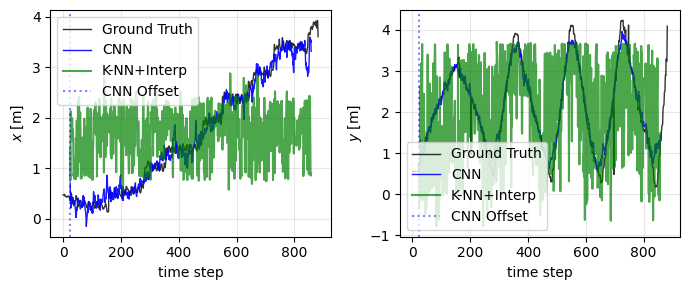

--------------------


--------------------
Experiment 6
Running sequential inference on 1817 windows...
Running K-NN inference on 1865 samples...

SEQUENTIAL INFERENCE PERFORMANCE SUMMARY
CNN Error: 0.097 ± 0.093 m
K-NN Error: 1.874 ± 1.103 m
K-NN+Interp Error: 1.585 ± 0.885 m
K-NN samples: 1865
Database built with normalized location data
CNN samples: 1817
CNN time range: 24 to 1840 (1817 points)
K-NN time range: 0 to 1864 (1865 points)
Overlap period: 24 to 1840 (1817 points)
CNN est. ofs.: 24 (window_size=49)


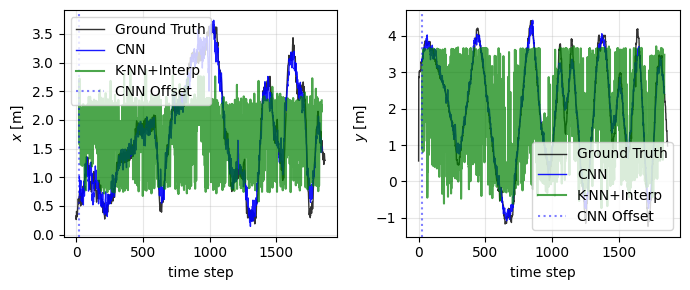

--------------------


--------------------
Experiment 7
Running sequential inference on 2269 windows...
Running K-NN inference on 2317 samples...

SEQUENTIAL INFERENCE PERFORMANCE SUMMARY
CNN Error: 0.097 ± 0.090 m
K-NN Error: 1.865 ± 1.003 m
K-NN+Interp Error: 1.584 ± 0.838 m
K-NN samples: 2317
Database built with normalized location data
CNN samples: 2269
CNN time range: 24 to 2292 (2269 points)
K-NN time range: 0 to 2316 (2317 points)
Overlap period: 24 to 2292 (2269 points)
CNN est. ofs.: 24 (window_size=49)


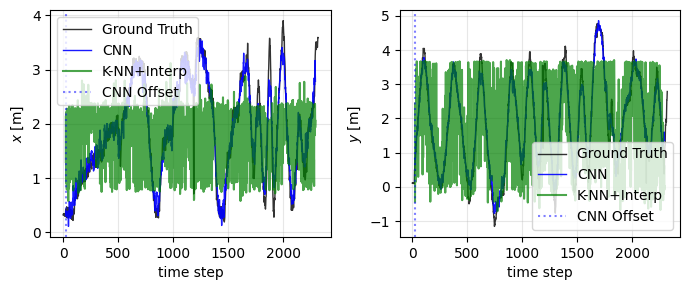

--------------------


--------------------
Experiment 8
Running sequential inference on 1044 windows...
Running K-NN inference on 1092 samples...

SEQUENTIAL INFERENCE PERFORMANCE SUMMARY
CNN Error: 0.144 ± 0.150 m
K-NN Error: 2.376 ± 1.074 m
K-NN+Interp Error: 2.037 ± 0.961 m
K-NN samples: 1092
Database built with normalized location data
CNN samples: 1044
CNN time range: 24 to 1067 (1044 points)
K-NN time range: 0 to 1091 (1092 points)
Overlap period: 24 to 1067 (1044 points)
CNN est. ofs.: 24 (window_size=49)


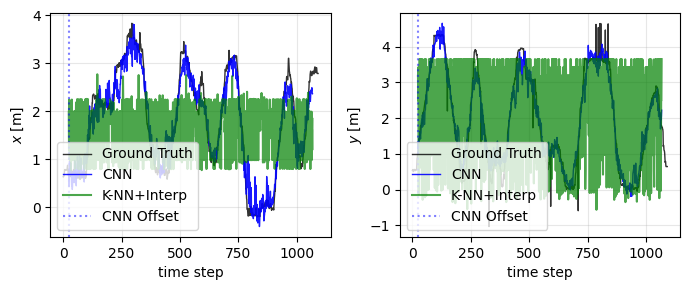

--------------------




In [24]:
for i in range(5,9):
    print("-"*20)
    print("Experiment", i)
    datajsonpath = "../experiments/exp00"+str(i)+"_20250526_sna_kadirerdem/data-tshark/data.json"
    inp_rss_vals, gt_locations = loadData_staticTargetAddrMatch(datajsonpath, second_hold = 5, shuffle=False, 
                                                                target_addresses=target_adresses, snap250ms=False)
    # Normalize your data before training
    inp_rss_vals_norm, gt_locations_norm, _ = apply_normalization(inp_rss_vals, gt_locations, norm_params)
    sequential_loader, xts_full, yts_full = create_sequential_inference_loader(inp_rss_vals=inp_rss_vals_norm, 
                                                                               gt_locations=gt_locations_norm, 
                                                                               window_size=window_size, cnn_data=True, 
                                                                               cnn_kernel_sizes=kernel_sizes)
    cnn = RssPosAlgo_NeuralNet_CNNv1(channels, kernel_sizes)
    cnn.load_state_dict(torch.load('savedmodels/dev16_cnn.pth'));
    cnn.eval();
    cnn.cuda();
    sequential_results = run_sequential_inference(sequential_loader, cnn, xts_full, yts_full, norm_params, 
                                                  RssPosAlgo_NearestNeighbour, RssPosAlgo_NearestNeighbour_Interpolation,
                                                  db_kmeans=db_kmeans)
    plot_sequential_results(sequential_results, num_clusters=num_clusters, window_size=window_size)
    print("-"*20)
    print("")
    print("")